## Lecture 8 – Data 100, Summer 2022

by Anirudhan Badrinath

Content from Anirudhan Badrinath, Lisa Yan, Suraj Rampure, Ani Adhikari, and Data 8 Textbook Chapter 15

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

### Correlation

Recreate the 4 correlation plots in slides (Normally this wouldn't be in the notebook, but it might be of interest to you.)

Note: We use `np.corrcoef` to compute the correlation coefficient $r$, though we could also compute manually too.

In [ ]:
# set random seed recreate same random points as slides
np.random.seed(43)
plt.style.use('default') # revert style to default mpl

def plot_and_get_corr(ax, x, y, title):
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(x, y, alpha=0.73)
    ax.set_title(title)
    return np.corrcoef(x, y)[0, 1]

fig, axs = plt.subplots(2,2,figsize=(10,10))

# just noise
x1, y1 = np.random.randn(2, 100)
corr1 = plot_and_get_corr(axs[0, 0], x1, y1, title="noise")


# strong linear
x2 = np.linspace(-3, 3, 100)
y2 = x2*0.5 - 1 + np.random.randn(100)*0.3
corr2 = plot_and_get_corr(axs[0, 1], x2, y2, title="strong linear")


# unequal spread
x3 = np.linspace(-3, 3, 100)
y3 = - x3/3 + np.random.randn(100)*(x3)/2.5
corr3 = plot_and_get_corr(axs[1, 0], x3, y3, title="strong linear")
extent = axs[1, 0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('ax3_figure.png', bbox_inches=extent)


# strong non-linear
x4 = np.linspace(-3, 3, 100)
y4 = 2*np.sin(x3 - 1.5) + np.random.randn(100)*0.3
corr4 = plot_and_get_corr(axs[1, 1], x4, y4, title="strong non-linear")
# extent = axs[1, 1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig('ax4_figure.png', bbox_inches=extent)

plt.show()
print([corr1, corr2, corr3, corr4])

## Which $\theta$ is best?


In [ ]:
plt.style.use('fivethirtyeight')
lw = pd.read_csv("little_women.csv")
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
sns.scatterplot(data=lw, x="Periods", y="Characters", ax=ax)

xlims = np.array([50, 450])
params = [[5000, 100], [50000, -50], [-4000, 150]]
for i, (a, b) in enumerate(params):
    ax.plot(xlims, a + b * xlims, lw=2, label=f"{i+1}. (a: {a}, b: {b})")
ax.legend()

# the best parameters weren't one of the choices
ahat_true, bhat_true = 4745, 87
fig.tight_layout()
plt.savefig('lw_params.png')

## Simple Linear Regression

First, let's implement the tools we'll need for regression.

In [2]:
def standard_units(x):
    return (x - np.mean(x)) / np.std(x)

def correlation(x, y):
    return np.mean(standard_units(x) * standard_units(y))

Let's read in our data!

In [3]:
df = pd.read_csv('disc_vs_score.csv')
df

,disc_score,overall_score
0,13.0,86.0
1,13.0,85.0
2,3.0,89.0
3,9.0,87.0
4,13.0,81.0
...,...,...
984,10.0,83.0
985,13.0,80.0
986,NaN,71.0
987,11.0,92.0


Let's plot this data using a typical scatterplot using Seaborn!

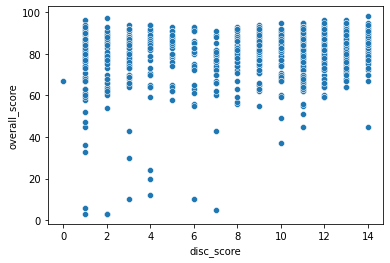

In [4]:
sns.scatterplot(data = df, x = 'disc_score', y = 'overall_score');

Pretty hard to see what's going on here, so let's groupby each potential discussion attendance score and find the mean overall score for each, plotting that!

There's a much clearer trend here.

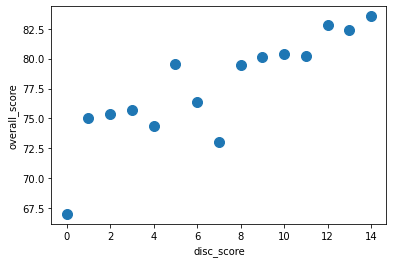

In [5]:
df.groupby('disc_score')['overall_score'].mean().plot(style = '.', markersize = 20)
plt.ylabel('overall_score');

Seaborn can perform a similar procedure for us using binning (or discretization).

*Note*: the "ideal" plot for this from our visualization repertoire is 14 boxplots stacked horizontally - however, this ends up masking the trends due to a *lot* of outliers and too much variance to draw conclusions about the mean. Keep in mind that we've "masked" the variance of the data here a lot more ("hidden").

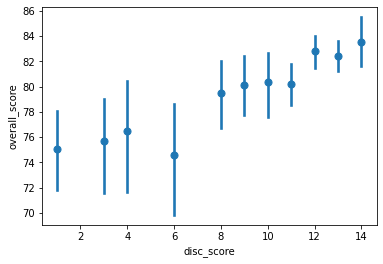

In [6]:
sns.regplot(data = df, x = 'disc_score', y = 'overall_score', x_bins = 14, fit_reg = False);

Using our `correlation` function:

In [7]:
correlation(df['disc_score'], df['overall_score'])

0.23372372704380598

Using an in-built `correlation` function:
* The matrix elements are symmetric: elements are correlations of (x, x), (x, y), (y, x), and (y, y).
* NumPy and pandas functions.

In [8]:
df.corr()

,disc_score,overall_score
disc_score,1.000000,0.240342
overall_score,0.240342,1.000000


In [9]:
def slope(x, y):
    return correlation(x, y) * np.std(y) / np.std(x)

def intercept(x, y):
    return np.mean(y) - slope(x, y)*np.mean(x)

In [10]:
ahat = intercept(df['disc_score'], df['overall_score'])
bhat = slope(df['disc_score'], df['overall_score'])

print("predicted overall score = {} + {} * discussion score".format(np.round(ahat, 2), np.round(bhat, 2)))

predicted overall score = 73.22 + 0.7 * discussion score


Let's see what our linear model looks like.

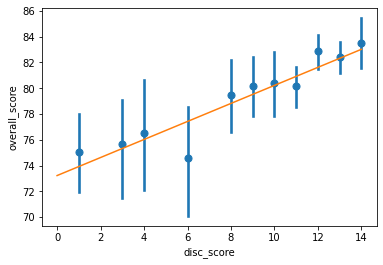

In [11]:
sns.regplot(data = df, x = 'disc_score', y = 'overall_score', x_bins = 14, fit_reg = False)
plt.plot(np.linspace(0, 14, 15), bhat * np.linspace(0, 14, 15) + ahat)

# Evaluating the Model

In [ ]:
# helper functions
def fit_least_squares(x, y):
    ahat = intercept(x, y)
    bhat = slope(x, y)
    return ahat, bhat

def predict(x, ahat, bhat):
    return ahat + bhat*x

def compute_mse(y, yhat):
    return np.mean((y - yhat)**2)

Below we define `least_squares_evaluation` which:
* Computes general data statistics like mean, standard deviation, and linear correlation $r$
* Fits least squares to data of the form $(x, y)$
* Computes performance metrics like RMSE
* Optionally plots two visualizations:
    * Original scatter plot with fitted line
    * Residual plot

In [ ]:
plt.style.use('default') # revert style to default mpl
NO_VIZ, RESID, RESID_SCATTER = range(3)
def least_squares_evaluation(x, y, visualize=NO_VIZ):
    # statistics
    print(f"x_mean : {np.mean(x):.2f}, y_mean : {np.mean(y):.2f}")
    print(f"x_stdev: {np.std(x):.2f}, y_stdev: {np.std(y):.2f}")
    print(f"r = Correlation(x, y): {correlation(x, y):.3f}")
    
    # performance metrics
    ahat, bhat = fit_least_squares(x, y)
    yhat = predict(x, ahat, bhat)
    print(f"ahat: {ahat:.2f}, bhat: {bhat:.2f}")
    print(f"RMSE: {np.sqrt(compute_mse(y, yhat)):.3f}")

    # visualization
    fig, ax_resid = None, None
    if visualize == RESID_SCATTER:
        fig, axs = plt.subplots(1,2,figsize=(8, 3))
        axs[0].scatter(x, y)
        axs[0].plot(x, yhat)
        axs[0].set_title("LS fit")
        ax_resid = axs[1]
    elif visualize == RESID:
        fig = plt.figure(figsize=(4, 3))
        ax_resid = plt.gca()
    
    if ax_resid is not None:
        ax_resid.scatter(x, y - yhat, color = 'red')
        ax_resid.plot([4, 14], [0, 0], color = 'black')
        ax_resid.set_title("Residuals")
    
    return fig

Let's first try just doing linear fit *without* visualizing data.

**Note**: Computation without visualization is NOT a good practice! We are doing the three evaluation steps **out of order** to highlight the importance of visualization.

Here are the evaluation steps **in order**:
1. Visualize original data, compute statistics
2. If it seems reasonable, fit linear model
3. Finally, compute performance metrics of linear model and plot residuals and other visualizations

In [ ]:
# Load in four different datasets: I, II, III, IV
anscombe = sns.load_dataset('anscombe')
anscombe['dataset'].value_counts()

### Compute statistics and performance metrics only

In [ ]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[anscombe['dataset'] == dataset]
    least_squares_evaluation(ans['x'], ans['y'], visualize=NO_VIZ)
    print()
    print()

Wow, looks like all four datasets have the same:
* statistics of $x$ and $y$
* correlation $r$
* regression line parameters $\hat{a}, \hat{b}$
* RMSE (average squared loss)

### Plot Residuals

In [ ]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[anscombe['dataset'] == dataset]
    fig = least_squares_evaluation(ans['x'], ans['y'], visualize=RESID)
    plt.show(fig)
    print()
    print()

### Visualize the original data (what we should have done at the beginning)

In [ ]:
for dataset in ['I', 'II', 'III', 'IV']:
    print(f">>> Dataset {dataset}:")
    ans = anscombe[anscombe['dataset'] == dataset]
    fig = least_squares_evaluation(ans['x'], ans['y'], visualize=RESID_SCATTER)
    plt.show(fig)
    print()
    print()